LOAD MODEL

In [1]:
import numpy as np 
import pandas as pd 
import torch
from tqdm import tqdm
import sys

import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
tqdm.pandas()
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
from PIL import Image
import ast

In [2]:
import torch
model = torch.hub.load('yolov5-lib-ds', 
                       'custom', 
                       path='models/best.pt',
                       source='local',
                       force_reload=True)  # local repo
model.conf = 0.25
model.iou  = 0.50  # NMS IoU threshold
model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image

YOLOv5 🚀 faff72c torch 1.10.0 CPU

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients, 16.2 GFLOPs
Adding AutoShape... 


In [3]:
def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes


def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, w, h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]



MAKE PREDICTION

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)


cpu


In [5]:
def show_img(img, bboxes, bbox_format='coco'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

647 494 703 557 confidence:  0.8396852612495422
642 353 709 410 confidence:  0.8388733863830566
310 382 371 432 confidence:  0.8338475227355957
599 331 659 377 confidence:  0.8275062441825867
444 512 479 551 confidence:  0.8141005635261536
847 520 923 586 confidence:  0.7968049049377441
565 376 618 431 confidence:  0.7885143160820007
218 299 251 332 confidence:  0.7750746011734009
1100 429 1169 480 confidence:  0.7666950821876526
567 338 619 388 confidence:  0.7590019702911377
382 424 416 455 confidence:  0.758010983467102
272 276 317 310 confidence:  0.7464346289634705
449 139 487 170 confidence:  0.6855655312538147
377 131 405 157 confidence:  0.5246832966804504
494 168 532 203 confidence:  0.3002586364746094


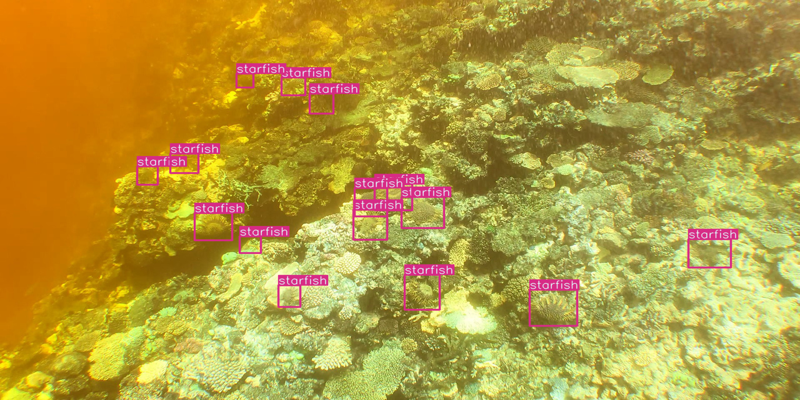

In [19]:
import cv2
img_id_original = '1-9144'
img= './test_images/'+img_id_original+'.jpg'
path=img
r = model(img, size=3600, augment=True)
preds   = r.pandas().xyxy[0]
bboxes  = preds[['xmin','ymin','xmax','ymax']].values
confs   = preds.confidence.values
bbclasses = preds['class'].values

bboxes_thr = []
for i in range(len(bboxes)):
    box = bboxes[i]
    cls_id = int(bbclasses[i])
    conf_single = confs[i]
    if conf_single < 0.28:
        continue
    bboxes_thr.append(box)
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])
    print(x_min, y_min, x_max, y_max, "confidence: ",conf_single)
img=cv2.imread(img)
display(show_img(img, bboxes_thr, bbox_format='coco'))

CHECK IT WITH ORIGINAL IMAGE

In [20]:
%matplotlib inline
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# === Show image and annotations if applicable ===
def show_image_original(path, annot, axs=None):
    if axs==None:
        fig, axs = plt.subplots(figsize=(23, 8))
    
    img = plt.imread(path)
    axs.imshow(img)

    if annot:
        for a in eval(annot):
            print(a)
            rect = patches.Rectangle((a["x"], a["y"]), a["width"], a["height"], 
                                     linewidth=3, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)
            axs.annotate("Starfish", (a["x"], a["y"]), color='w', weight='bold', 
                fontsize=10, va='center')

    axs.axis("off")

{'x': 488, 'y': 159, 'width': 38, 'height': 41}
{'x': 311, 'y': 380, 'width': 57, 'height': 54}
{'x': 644, 'y': 489, 'width': 57, 'height': 64}
{'x': 602, 'y': 329, 'width': 54, 'height': 43}
{'x': 568, 'y': 335, 'width': 45, 'height': 45}
{'x': 566, 'y': 381, 'width': 48, 'height': 40}
{'x': 856, 'y': 535, 'width': 65, 'height': 45}
{'x': 444, 'y': 511, 'width': 38, 'height': 45}
{'x': 275, 'y': 278, 'width': 40, 'height': 33}
{'x': 649, 'y': 355, 'width': 58, 'height': 48}
{'x': 1100, 'y': 428, 'width': 62, 'height': 49}
{'x': 215, 'y': 301, 'width': 39, 'height': 31}
{'x': 448, 'y': 137, 'width': 35, 'height': 28}


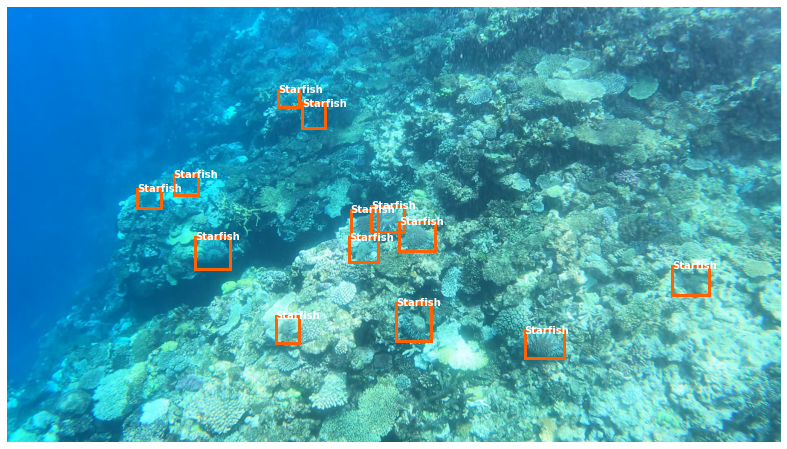

In [21]:
import pandas as pd

train_df = pd.read_csv("./train.csv")
#manually
x=train_df.loc[train_df['image_id'] == img_id_original]
annot = list(x['annotations'])[0]
show_image_original(path, annot, axs=None)